In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData
from fvt_classifier import FvTClassifier

def get_sigma_avg(events: EventsData, hist_values: np.ndarray, bins, reweights: np.ndarray):
    hist_3b, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=events.weights[events.is_3b])
    hist_4b, _ = np.histogram(hist_values[events.is_4b], bins=bins, 
                                weights=events.weights[events.is_4b])
    hist_3b_sq, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=(events.weights * reweights)[events.is_3b])
    sigma = (hist_4b - hist_3b) / np.sqrt(hist_4b + hist_3b_sq)
    sigma_avg = np.sqrt(np.mean(sigma**2))
    
    return sigma_avg

def plot_reweighted_samples(events_reweighted: EventsData, 
                            events_not_reweighted: EventsData,
                            hist_values: np.ndarray, 
                            fig: plt.Figure):
    gs = GridSpec(2, 2, figure=fig)
    for ax_cnt, quantile in enumerate([True, False]):
        if quantile:
            q = np.linspace(0, 1, 10)
            bins = np.quantile(hist_values, q)
        else:
            bins = np.linspace(np.min(hist_values), np.max(hist_values), 10)

        ax = fig.add_subplot(gs[ax_cnt, 0])
        hist_events_by_labels(events_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("Reweighted")
        ax.legend()
        ax = fig.add_subplot(gs[ax_cnt, 1])
        hist_events_by_labels(events_not_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("NOT Reweighted")
        ax.legend()

[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 163/163 [00:09<00:00, 17.12it/s, v_num=178, val_loss=0.693, train_loss=0.693]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 40/40 [00:03<00:00, 12.37it/s, avg_val_loss=0.694]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 40/40 [00:03<00:00, 12.37it/s, avg_val_loss=0.694]


[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 75/75 [00:04<00:00, 16.38it/s, v_num=179, val_loss=0.694, train_loss=0.693]


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


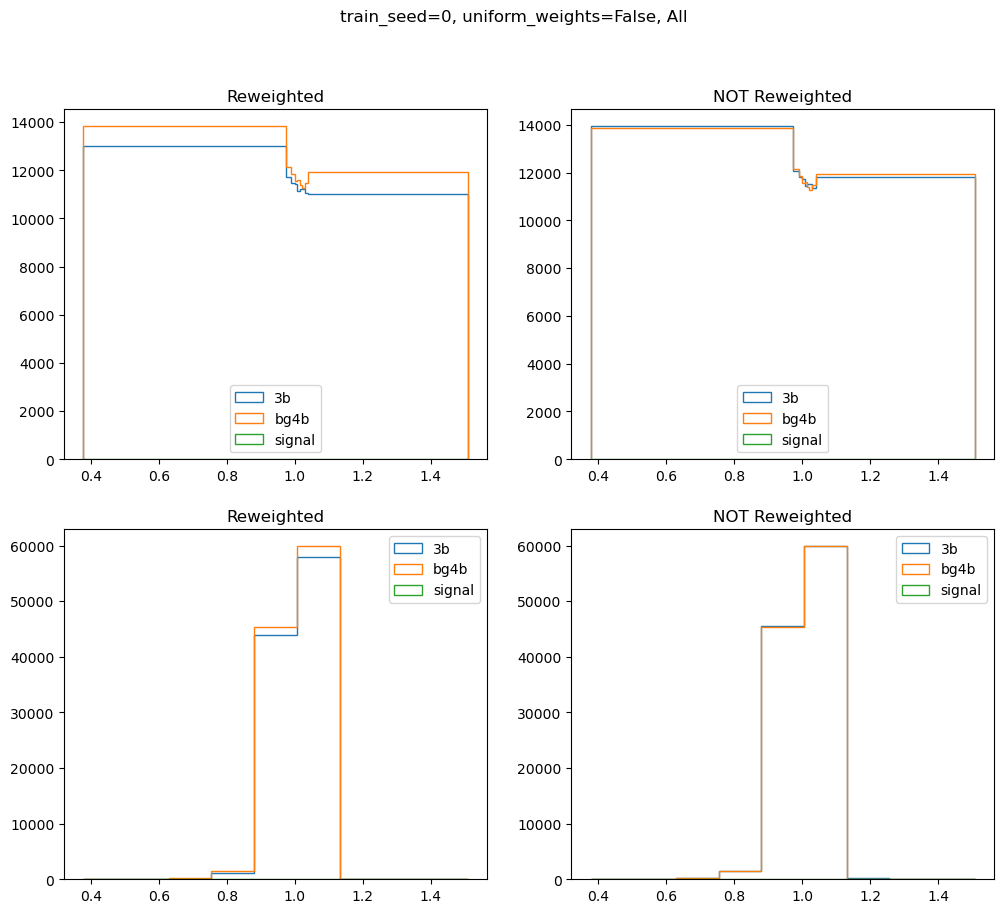

Reweighted / Quantile bins
3.1322153
NOT Reweighted / Quantile bins
0.69253975
Reweighted / Uniform bins
4.2084446
NOT Reweighted / Uniform bins
2.5421636


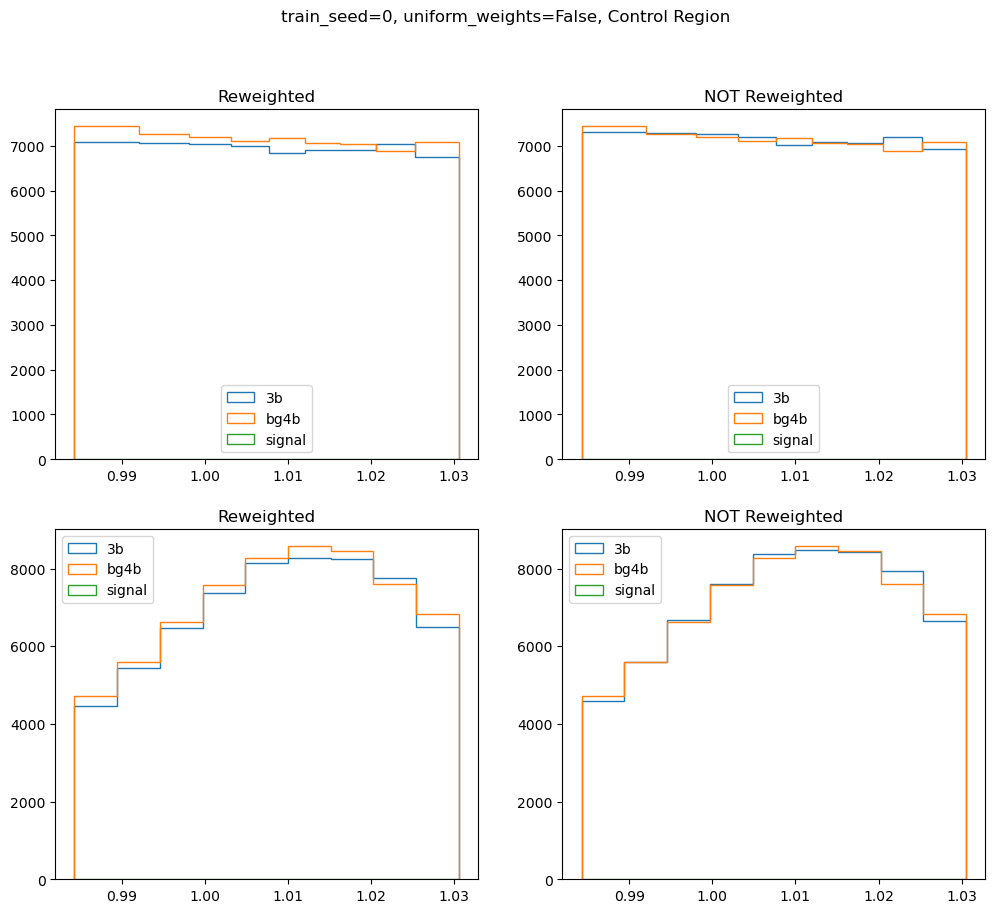

Reweighted / Quantile bins
1.8367217
NOT Reweighted / Quantile bins
1.0838562
Reweighted / Uniform bins
1.9819622
NOT Reweighted / Uniform bins
1.2269522


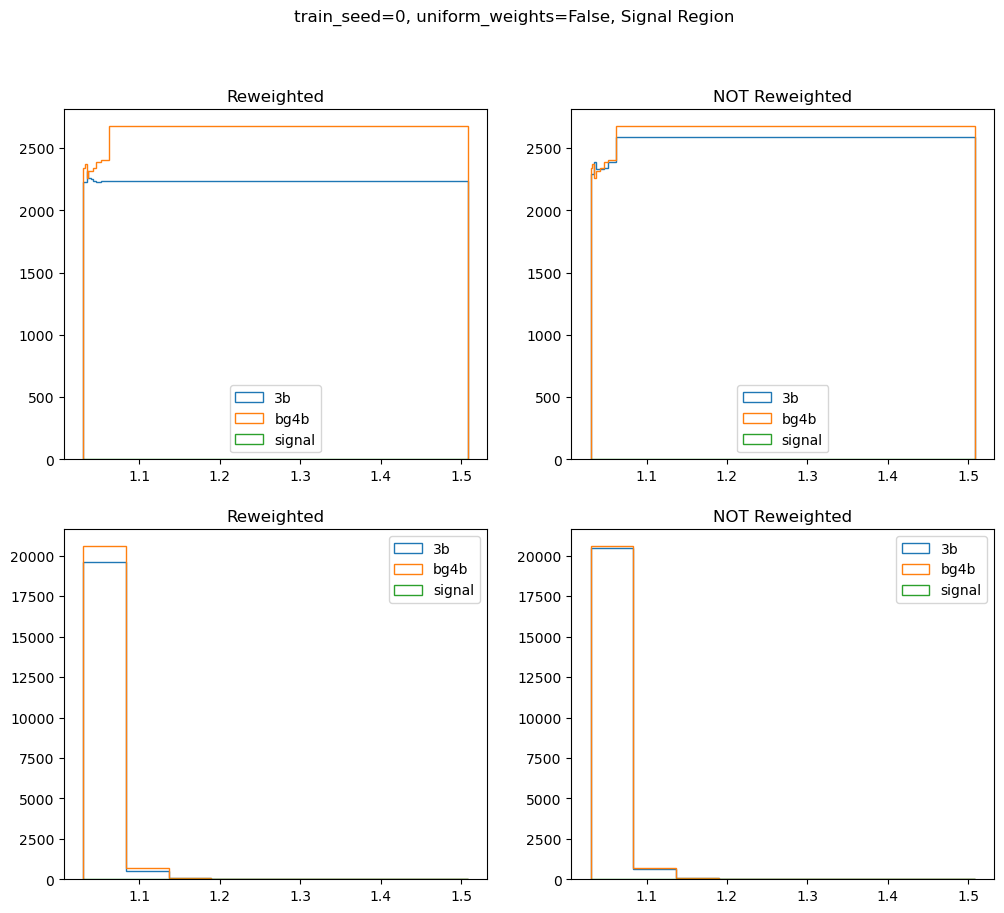

Reweighted / Quantile bins
2.78934
NOT Reweighted / Quantile bins
1.260783
Reweighted / Uniform bins
2.6614523
NOT Reweighted / Uniform bins
1.3853121


In [39]:
from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from signal_region import get_SR_stats
import itertools

dim_input_jet_features = 4
num_classes = 2

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 30,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.5
SR_train_ratio = 0.25

n_3b = 500_000
ratio_4b = 0.5
signal_ratio = 0.0
signal_filename = "HH4b_picoAOD.h5"
data_seed = 0
device = torch.device("cuda")

train_seeds = [0]
nbins = range(1, 11)
uniform_weights_list = [False]


# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=data_seed,
)

# Remove 4b events
df_all = df_all.iloc[:n_3b]
# give random "fourTag" labels
np.random.seed(data_seed)
df_all["fourTag"] = np.random.choice([0, 1], size=n_3b, p=[1 - ratio_4b, ratio_4b])
df_all["signal"] = False
df_all_uniform_weights = df_all.copy()
df_all_uniform_weights["weight"] = 1

sigma_dicts = []
probs_4b_ests = []
SR_stats = []

for train_seed in train_seeds:
    for uniform_weights in uniform_weights_list:
        
        if uniform_weights:
            events_all = EventsData.from_dataframe(df_all_uniform_weights, features)
        else:
            events_all = EventsData.from_dataframe(df_all, features)
            
        events_train, events_other = events_all.split(base_fvt_train_ratio, seed=data_seed)
        events_SR_train, events_tst = events_other.split(SR_train_ratio, seed=data_seed)
        
        pl.seed_everything(train_seed)
        np.random.seed(train_seed)
        
        base_fvt_hparams["train_seed"] = train_seed
        
        events_train, events_val = events_train.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
        events_train.fit_batch_size(base_fvt_hparams["batch_size"])
        events_val.fit_batch_size(base_fvt_hparams["batch_size"])
        
        base_fvt_train_dset = events_train.to_tensor_dataset()
        base_fvt_val_dset = events_val.to_tensor_dataset()
        
        base_fvt_model = FvTClassifier(
            num_classes,
            dim_input_jet_features,
            base_fvt_hparams["dim_dijet_features"],
            base_fvt_hparams["dim_quadjet_features"],
            run_name="",
            device=torch.device("cuda:0"),
            lr=base_fvt_hparams["lr"],
        )

        base_fvt_model.fit(
            base_fvt_train_dset,
            base_fvt_val_dset,
            batch_size=base_fvt_hparams["batch_size"],
            max_epochs=base_fvt_hparams["max_epochs"],
            train_seed=base_fvt_hparams["train_seed"],
            save_checkpoint=False, 
            callbacks=[],
        )
        base_fvt_model.to(device)
        base_fvt_model.eval()
        
        SR_stat = get_SR_stats(
            events_tst,
            fvt_model=base_fvt_model,
            method="smearing",
            events_SR_train=events_SR_train,
            noise_scale=0.1,
        )
        SR_stats.append(SR_stat)
        
        probs_4b_est = base_fvt_model.predict(events_other.X_torch).detach().cpu().numpy()[:, 1]
        probs_4b_ests.append(probs_4b_est)
        
        SR_stats_argsort = np.argsort(SR_stat)[::-1]
        SR_stats_sorted = SR_stat[SR_stats_argsort]

        weights = events_tst.weights[SR_stats_argsort]
        is_4b = events_tst.is_4b[SR_stats_argsort]
        cumul_4b_ratio = np.cumsum(weights * is_4b) / np.sum(weights * is_4b)

        w_4b_SR_ratio = 0.2
        w_4b_CR_ratio = 0.8

        SR_cut, CR_cut = None, None
        for i in range(1, len(cumul_4b_ratio)):
            if cumul_4b_ratio[i] > w_4b_SR_ratio and SR_cut is None:
                SR_cut = SR_stats_sorted[i - 1]
            if cumul_4b_ratio[i] > w_4b_CR_ratio and CR_cut is None:
                CR_cut = SR_stats_sorted[i - 1]
            if SR_cut is not None and CR_cut is not None:
                break

        # If the cut is not found, set the cut to the minimum value
        # Both SR and CR cuts should be different
        if SR_cut is None:
            SR_cut = SR_stats_sorted[-1]
        if CR_cut is None:
            CR_cut = SR_stats_sorted[-1]
        if SR_cut == CR_cut:
            raise ValueError("SR and CR cuts are the same")

        SR_idx = SR_stat >= SR_cut
        events_tst_SR = events_tst[SR_idx]

        CR_idx = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
        events_tst_CR = events_tst[CR_idx]
        
        events_CR_train, events_CR_val = events_tst_CR.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
        events_CR_train.fit_batch_size(base_fvt_hparams["batch_size"])
        events_CR_val.fit_batch_size(base_fvt_hparams["batch_size"])
        
        CR_fvt_train_dset = events_CR_train.to_tensor_dataset()
        CR_fvt_val_dset = events_CR_val.to_tensor_dataset()
        
        CR_fvt_model = FvTClassifier(
            num_classes,
            dim_input_jet_features,
            base_fvt_hparams["dim_dijet_features"],
            base_fvt_hparams["dim_quadjet_features"],
            run_name="",
            device=torch.device("cuda:0"),
            lr=base_fvt_hparams["lr"],
        )
        
        CR_fvt_model.fit(
            CR_fvt_train_dset,
            CR_fvt_val_dset,
            batch_size=base_fvt_hparams["batch_size"],
            max_epochs=base_fvt_hparams["max_epochs"],
            train_seed=base_fvt_hparams["train_seed"],
            save_checkpoint=False,
            callbacks=[],
        )
        CR_fvt_model.to(device)
        CR_fvt_model.eval()
        
        probs_4b_est_CR = CR_fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
        events_tst_clone = events_tst.clone()
        reweights = probs_4b_est_CR / (1 - probs_4b_est_CR) * (ratio_4b / (1 - ratio_4b))
        events_tst_clone.reweight(
            np.where(events_tst_clone.is_4b, 
                    events_tst_clone.weights, 
                    events_tst_clone.weights * reweights)
        )
        
        sigma_dict = {}
        
        for nbin, quantile, reweighted, region in itertools.product(nbins, 
                                                                    [True, False], 
                                                                    [True, False], 
                                                                    ["all", "CR", "SR"]):
            
            if region == "all":
                region_idx = np.ones_like(SR_stat, dtype=bool)
            elif region == "CR":
                region_idx = CR_idx
            elif region == "SR":
                region_idx = SR_idx
            else:
                raise ValueError("Invalid region")
            
            if quantile:
                q = np.linspace(0, 1, nbin + 1)
                bins = np.quantile(SR_stat[region_idx], q)
            else:
                bins = np.linspace(np.min(SR_stat[region_idx]), np.max(SR_stat[region_idx]), nbin)
                
            if reweighted:
                sigma_avg = get_sigma_avg(events_tst_clone[region_idx], 
                                          SR_stat[region_idx], 
                                          bins, 
                                          reweights[region_idx])
            else:
                sigma_avg = get_sigma_avg(events_tst[region_idx], 
                                          SR_stat[region_idx], 
                                          bins, 
                                          reweights=1)
        
            sigma_dict[(uniform_weights, reweighted, region, quantile, nbin)] = sigma_avg

        sigma_dicts.append(sigma_dict)
            
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, All")
        plot_reweighted_samples(events_tst_clone, events_tst, SR_stat, fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, True, "all", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, False, "all", True, 10)])
        print("Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, True, "all", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, False, "all", False, 10)])
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, Control Region")
        plot_reweighted_samples(events_tst_clone[CR_idx], events_tst[CR_idx], SR_stat[CR_idx], fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, True, "CR", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, False, "CR", True, 10)])
        print("Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, True, "CR", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, False, "CR", False, 10)])
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, Signal Region")
        plot_reweighted_samples(events_tst_clone[SR_idx], events_tst[SR_idx], SR_stat[SR_idx], fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, True, "SR", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(sigma_dict[(uniform_weights, False, "SR", True, 10)])
        print("Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, True, "SR", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(sigma_dict[(uniform_weights, False, "SR", False, 10)])

In [40]:
# Estimating Calibration Error of the FvT model
# Just use piecewise linear function for now

probs_4b_est = CR_fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]

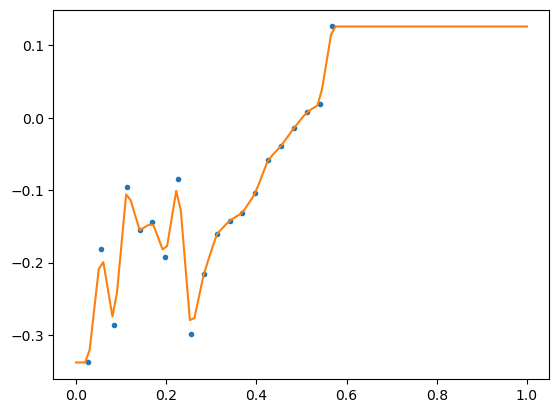

[4.960712  2.8563297 2.7217238 1.2484705 1.2466202 2.4366388 0.9017991
 1.6826836 1.6956598 6.50867  ]
[ 0.60238795  0.71421744  0.60062542 -0.80446689 -0.62326168  0.68992402
 -0.75526157 -0.04393173 -0.34280422  2.14115924]


In [41]:
nbins = 10
calibration_nbins = 20

calibration_bins = np.linspace(np.min(probs_4b_est), np.max(probs_4b_est), calibration_nbins + 1)
midpoints = (calibration_bins[1:] + calibration_bins[:-1]) / 2
hist_4b, _ = np.histogram(probs_4b_est, bins=calibration_bins, weights=(events_tst.weights * events_tst.is_4b))
hist_all, _ = np.histogram(probs_4b_est, bins=calibration_bins, weights=events_tst.weights)
mean_probs_4b = hist_4b / hist_all
calibration_error = midpoints - mean_probs_4b

def piecewise_linear(x_knots, y_knots):
    def piecewise_linear_inner(x):
        return np.interp(x, x_knots, y_knots)
    return piecewise_linear_inner

plt.plot(midpoints, calibration_error, "o")
x_range = np.linspace(0, 1, 100)
calibration_error_fn = piecewise_linear(midpoints, calibration_error)
plt.plot(x_range, calibration_error_fn(x_range))
plt.show()

bias = calibration_error_fn(probs_4b_est) * (1 / (1 - probs_4b_est))**2

q = np.linspace(0, 1, nbins + 1)
bins = np.quantile(SR_stat, q)
hist_bias, _ = np.histogram(SR_stat[events_tst_clone.is_3b], 
                            bins=bins, weights=(events_tst.weights * bias)[events_tst_clone.is_3b])
hist_3b, _ = np.histogram(SR_stat[events_tst_clone.is_3b], 
                          bins=bins, weights=events_tst_clone.weights[events_tst_clone.is_3b])
hist_3b_sq, _ = np.histogram(SR_stat[events_tst_clone.is_3b], 
                             bins=bins, weights=(events_tst_clone.weights * reweights)[events_tst_clone.is_3b])
hist_4b, _ = np.histogram(SR_stat[events_tst_clone.is_4b], bins=bins, weights=events_tst_clone.weights[events_tst_clone.is_4b])

sigma = (hist_4b - hist_3b) / np.sqrt(hist_4b + hist_3b_sq)
sigma_bias_fixed = (hist_4b - (hist_3b - hist_bias)) / np.sqrt(hist_4b + hist_3b_sq)

print(sigma)
print(sigma_bias_fixed)



In [69]:
def get_histograms(events_original: EventsData, values: np.ndarray, bins, 
                   reweights: np.ndarray=1):
    is_3b = events_original.is_3b
    is_bg4b = events_original.is_bg4b
    is_signal = events_original.is_signal
    
    hist_3b, _ = np.histogram(values[is_3b], bins=bins, weights=events_original.weights[is_3b])
    hist_bg4b, _ = np.histogram(values[is_bg4b], bins=bins, weights=events_original.weights[is_bg4b])
    hist_signal, _ = np.histogram(values[is_signal], bins=bins, weights=events_original.weights[is_signal])
    hist_3b_rw, _ = np.histogram(values[is_3b], bins=bins, weights=(events_original.weights * reweights)[is_3b])
    hist_3b_rw_sq, _ = np.histogram(values[is_3b], bins=bins, weights=(events_original.weights * reweights**2)[is_3b])
    
    hist_4b = hist_bg4b + hist_signal
    hist_all = hist_3b + hist_4b
    
    return {
        "3b": hist_3b,
        "bg4b": hist_bg4b,
        "signal": hist_signal,
        "4b": hist_4b,
        "3b_rw": hist_3b_rw,
        "3b_rw_sq": hist_3b_rw_sq,
        "all": hist_all,
    }
    
def get_bias_fn(events_original: EventsData, probs_4b_est: np.ndarray, calibration_nbin):
    assert len(events_original) == len(probs_4b_est)
    
    calibration_bins = np.linspace(np.min(probs_4b_est), np.max(probs_4b_est), calibration_nbin + 1)
    midpoints = (calibration_bins[1:] + calibration_bins[:-1]) / 2
    histograms = get_histograms(events_original, probs_4b_est, calibration_bins, 1)
    hist_4b = histograms["4b"]
    hist_all = histograms["all"]
    mean_probs_4b = hist_4b / hist_all
    calibration_error = midpoints - mean_probs_4b
    
    def piecewise_linear(x_knots, y_knots):
        def piecewise_linear_inner(x):
            return np.interp(x, x_knots, y_knots)
        return piecewise_linear_inner
    
    calib_error_fn = piecewise_linear(midpoints, calibration_error)
    
    def bias_fn(x):
        return calib_error_fn(x) * (1 / (1 - x))**2
    
    return bias_fn
    
    
def get_histogram_info(events_original: EventsData, values, bins, reweights, bias=None):
    assert len(events_original) == len(values)
    
    if isinstance(bins, int):
        # calculate quantiles
        q = np.linspace(0, 1, bins + 1)
        bins = np.quantile(values, q)
    
    if bias is not None:
        hist_bias, _ = np.histogram(values[events_original.is_3b],
                                    bins=bins, weights=(events_original.weights * bias)[events_original.is_3b])
        
    histograms = get_histograms(events_original, values, bins, reweights)
    hist_bg4b = histograms["bg4b"]
    hist_4b = histograms["4b"]
    hist_3b_rw = histograms["3b_rw"]
    hist_3b_rw_sq = histograms["3b_rw_sq"]

    std_est = np.sqrt(hist_4b + hist_3b_rw_sq)
    is_sampled = std_est > 0
    
    if bias is not None:
        sigma = (hist_4b - (hist_3b_rw - hist_bias))[is_sampled]  / std_est[is_sampled]
    else:
        sigma = (hist_4b - hist_3b_rw)[is_sampled]  / std_est[is_sampled]
    
    sigma_avg = np.sqrt(np.mean(sigma**2))
    
    if bias is not None:
        sigma_bg4b = (hist_bg4b - (hist_3b_rw - hist_bias))[is_sampled] / std_est[is_sampled]
    else:
        sigma_bg4b = (hist_bg4b - hist_3b_rw)[is_sampled] / std_est[is_sampled]
        
    sigma_avg_bg4b = np.sqrt(np.mean(sigma_bg4b**2))
    df = np.sum(is_sampled)
    
    histograms.update({
        "bias": hist_bias,
        "std_est": std_est,
        "sigma": sigma,
        "sigma_avg": sigma_avg,
        "sigma_bg4b": sigma_bg4b,
        "sigma_avg_bg4b": sigma_avg_bg4b,
        "df": df,
    })

    return histograms

  0%|          | 0/51 [00:00<?, ?it/s]

************************
seed:  0 signal_ratio:  0.0 rw_method:  CR


100%|██████████| 1547/1547 [00:19<00:00, 80.40it/s]


hist_bias_3b_rw:  [ 972.57709835 -550.14408543 -188.32980453 1458.92832462  840.50209611
  656.73622097  632.891922    701.60837966  895.97759655]
[-3.76073091 -3.63176857 -0.67906159  0.33152148  0.75391326  0.70348704
  1.870434    2.02093672  3.24219577]
hist_3b_rw:  [53434.0439954  69823.19096043 80930.05636703 95888.71230038
 97035.09165389 96305.17002903 94814.139328   93552.57912034
 92645.08490345]
hist_3b_rw_sq:  [ 21800.658  43229.28   79897.16  156341.19  150292.62  140885.28
 132144.69  125681.375 123462.75 ]
hist_bg4b:  [52409.562 68608.65  80657.96  96055.266 97410.31  96648.03  95706.97
 94500.875 94157.56 ]
hist_bias_3b_rw:  [ 972.57709835 -550.14408543 -188.32980453 1458.92832462  840.50209611
  656.73622097  632.891922    701.60837966  895.97759655]


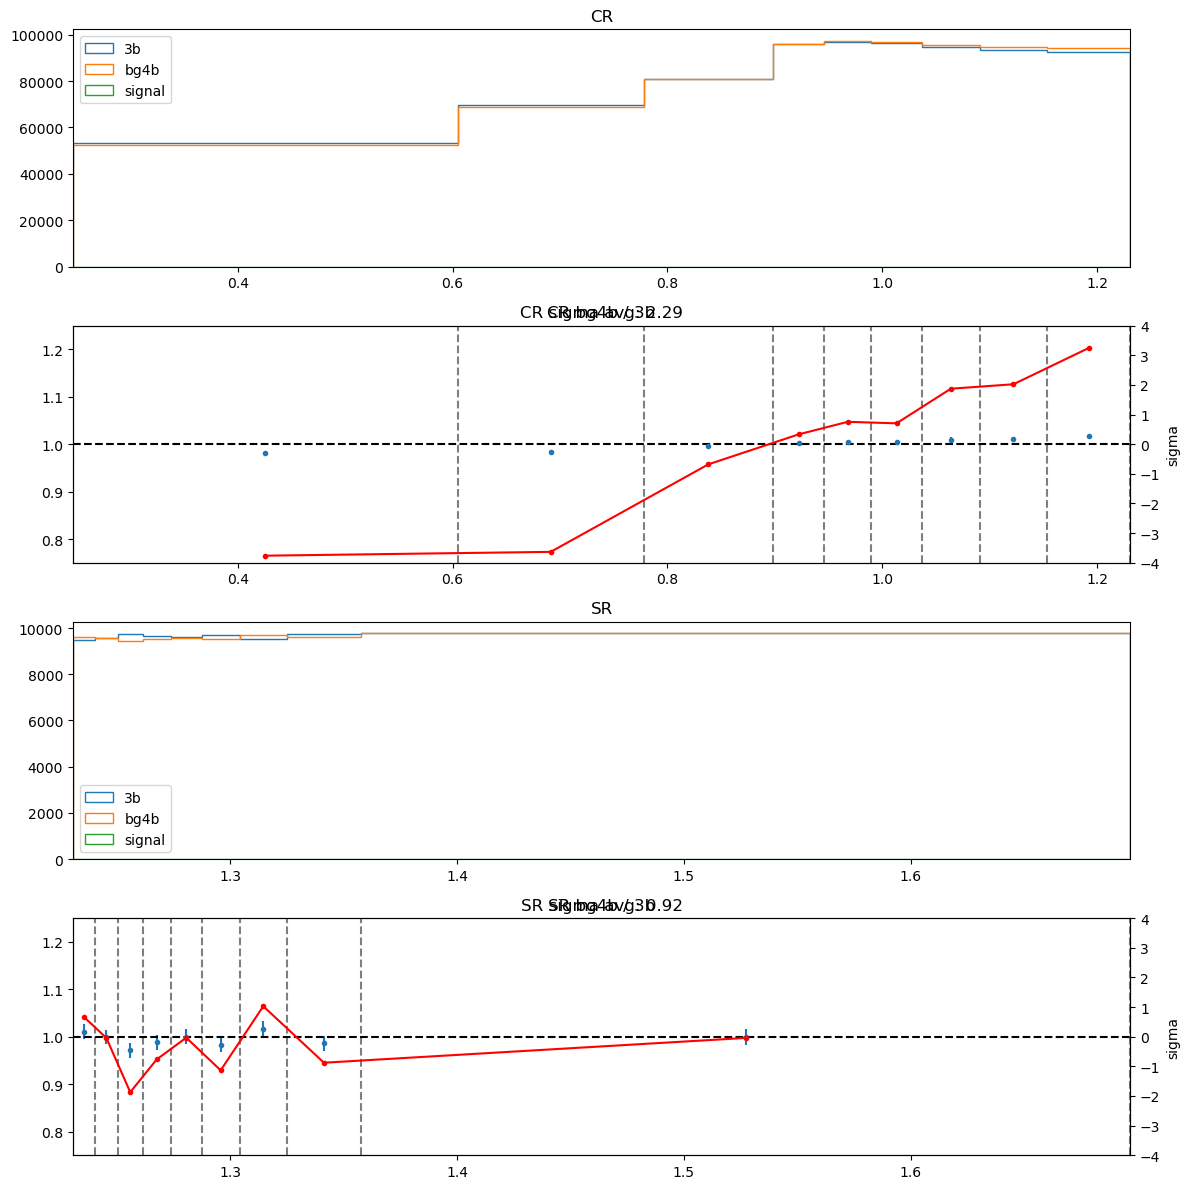

[-3.76073091 -3.63176857 -0.67906159  0.33152148  0.75391326  0.70348704
  1.870434    2.02093672  3.24219577]
hist_3b_rw:  [54406.62 69273.05 80741.73 97347.64 97875.59 96961.91 95447.03 94254.19
 93541.06]
hist_3b_rw_sq:  [ 21800.658  43229.28   79897.16  156341.19  150292.62  140885.28
 132144.69  125681.375 123462.75 ]
hist_bg4b:  [52409.562 68608.65  80657.96  96055.266 97410.31  96648.03  95706.97
 94500.875 94157.56 ]
hist_bias:  [ 972.57709835 -550.14408543 -188.32980453 1458.92832462  840.50209611
  656.73622097  632.891922    701.60837966  895.97759655]


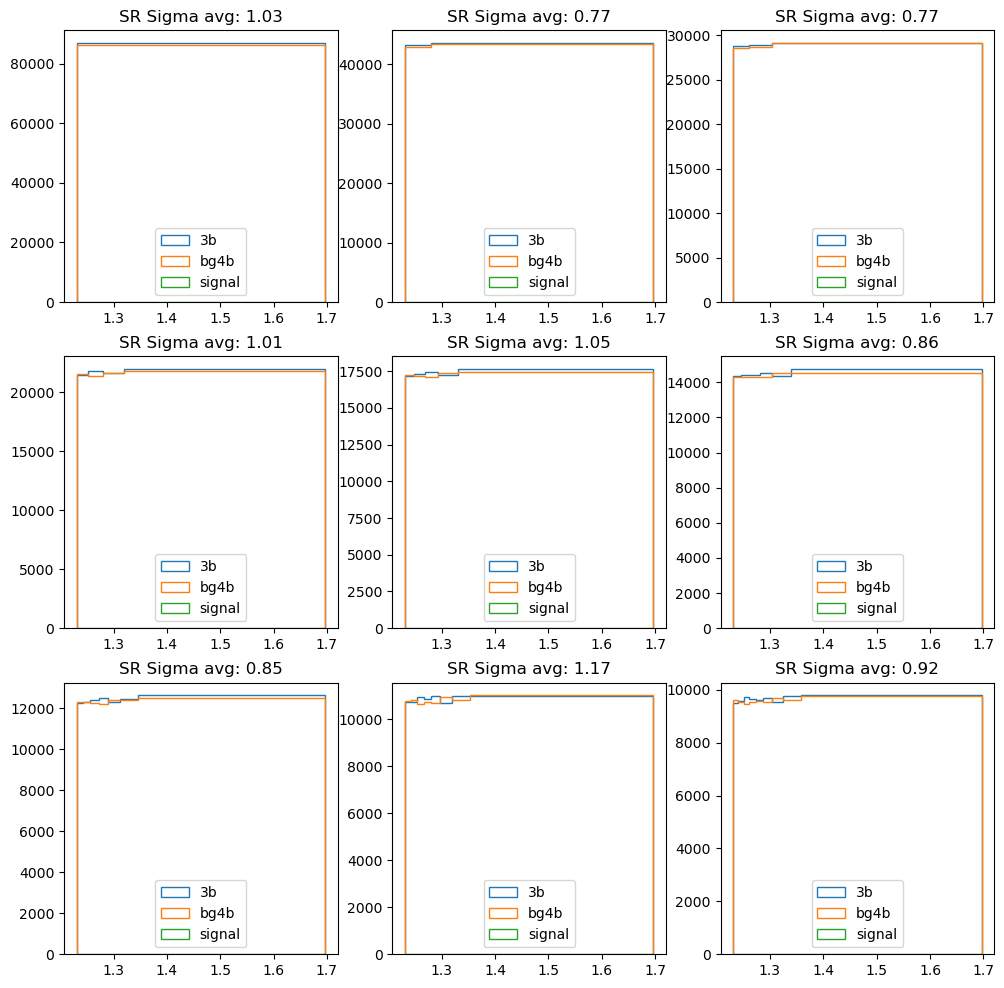

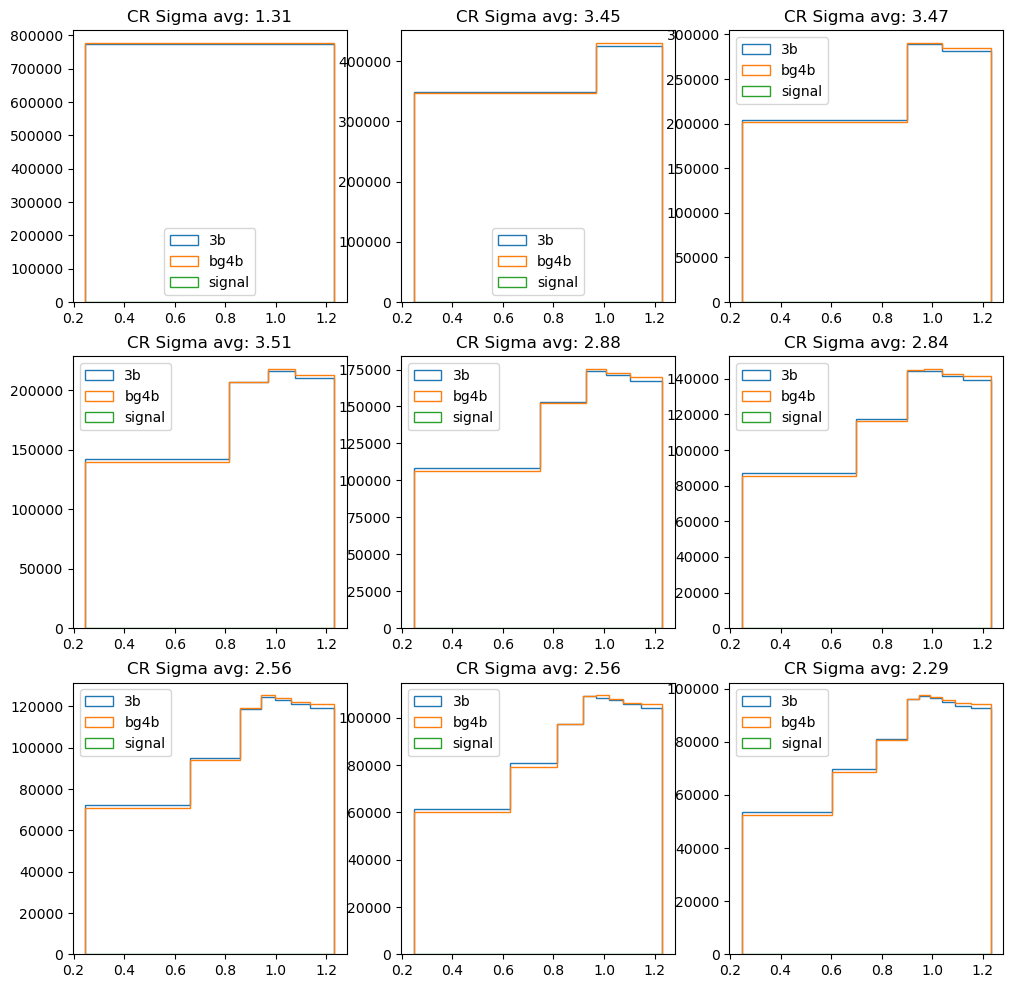

************************
seed:  0 signal_ratio:  0.0 rw_method:  base



  0%|          | 0/51 [00:34<?, ?it/s]


KeyboardInterrupt: 

In [70]:
import sys
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from events_data import events_from_scdinfo
from tst_info import TSTInfo

plt.rcParams["lines.markersize"] = 3

verbose = False
show_plots = False
n_3b = 140_0000
device = torch.device("cuda")
do_tqdm = True
calibration_nbin = 20

hparam_filter = {
    "experiment_name": lambda x: x in ["counting_test_high_4b_in_CR"], 
    "n_3b": n_3b,
    "signal_ratio": 0.0,
}

experiment_name = "counting_test_high_4b_in_CR"
df_name = f"./data/tsv/tst_results_summary_{experiment_name}_n_3b={n_3b}_debiased.tsv"

if not os.path.exists(df_name):
    tst_results_summary_df = pd.DataFrame()
else:
    tst_results_summary_df = pd.read_csv(df_name, sep="\t")


hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])
tst_results_summary = []

for tstinfo_hash in (pbar := tqdm.tqdm(hashes)):
    
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    experiment_name = tstinfo.hparams["experiment_name"]
    
    if tst_results_summary_df.shape[0] > 0:
        if ((tst_results_summary_df["signal_ratio"] == signal_ratio) & (tst_results_summary_df["seed"] == seed)).any():
            continue
    
    initialize_with_fvt = True

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.to(device)
    fvt_model.freeze()
    
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.to(device)
    CR_model.freeze()

    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)
    
    ratio_4b = tstinfo.hparams["ratio_4b"]
    
    for rw_method in ["CR", "base"]:
        print("************************")
        print("seed: ", seed, "signal_ratio: ", signal_ratio, "rw_method: ", rw_method)
        if rw_method == "CR":
            probs_4b_est = CR_model.predict(events_tst.X_torch, do_tqdm=do_tqdm).detach().cpu().numpy()[:, 1]
        else:
            probs_4b_est = fvt_model.predict(events_tst.X_torch, do_tqdm=do_tqdm).detach().cpu().numpy()[:, 1]

        reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
        bias_fn = get_bias_fn(events_tst, probs_4b_est, calibration_nbin)
        bias_3b_rw = bias_fn(probs_4b_est)
        
        events_SR = events_tst[in_SR]
        events_CR = events_tst[in_CR]
        SR_stats_SR = SR_stats[in_SR]
        SR_stats_CR = SR_stats[in_CR]
        
        events_tst_rw = events_tst.clone()
        # include bias
        events_tst_rw.reweight(
            np.where(events_tst_rw.is_4b, events_tst_rw.weights, events_tst_rw.weights * (reweights - bias_3b_rw)))
        events_SR_rw = events_tst_rw[in_SR]
        events_CR_rw = events_tst_rw[in_CR]

        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(4, 1, figure=fig)

        # bins = np.linspace(np.min(SR_stats_CR), np.max(SR_stats_CR), 10)
        q = np.linspace(0, 1, 10)
        bins = np.quantile(SR_stats_CR, q)

        ax = fig.add_subplot(gs[0])
        hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins, ax=ax)
        ax.set_xlim((bins[0], bins[-1]))
        ax.set_title("CR")
        ax.legend()
        
        histograms = get_histograms(events_CR, SR_stats_CR, bins, reweights[in_CR])
        hist_3b_rw = histograms["3b_rw"]
        hist_3b_rw_sq = histograms["3b_rw_sq"]
        hist_bg4b = histograms["bg4b"]
        hist_bias_3b_rw, _ = np.histogram(SR_stats_CR[events_CR.is_3b], bins=bins, 
                                          weights=(events_CR.weights * bias_3b_rw[in_CR])[events_CR.is_3b])
        print("hist_bias_3b_rw: ", hist_bias_3b_rw)

        
        # debiasing
        hist_3b_rw = hist_3b_rw - hist_bias_3b_rw
        
        ax = fig.add_subplot(gs[1])
        midpoints = (bins[1:] + bins[:-1]) / 2
        err = np.sqrt(hist_bg4b / hist_3b_rw**2 + hist_3b_rw_sq * (hist_bg4b / hist_3b_rw**2)**2)
        ax.errorbar(midpoints, hist_bg4b / hist_3b_rw, yerr=err, label="bg4b / 3b", fmt="o", markersize=3)
        ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
        ax.set_xlim((bins[0], bins[-1]))
        ax.set_ylim((0.75, 1.25))
        ax.set_title("CR bg4b / 3b")
        ymin, ymax = ax.get_ylim()
        ax.vlines(bins, ymin, ymax, color="black", linestyle="--", alpha=0.5)

        ax2 = ax.twinx()
        sigma = (hist_bg4b - hist_3b_rw) / np.sqrt(hist_bg4b + hist_3b_rw_sq)
        ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
        ax2.set_ylim((-4, 4))
        ax2.set_ylabel("sigma")
        ax2.set_title("CR sigma avg: {:.2f}".format(np.sqrt(np.mean(sigma**2))))
        
        print(sigma)
        print("hist_3b_rw: ", hist_3b_rw)
        print("hist_3b_rw_sq: ", hist_3b_rw_sq)
        print("hist_bg4b: ", hist_bg4b)
        print("hist_bias_3b_rw: ", hist_bias_3b_rw)
        
        
        q = np.linspace(0, 1, 10)
        bins = np.quantile(SR_stats_SR, q)

        ax = fig.add_subplot(gs[2])
        hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins, ax=ax)
        ax.set_xlim((bins[0], bins[-1]))
        ax.set_title("SR")
        ax.legend()
        
        histograms = get_histograms(events_SR, SR_stats_SR, bins, reweights[in_SR])
        hist_3b_rw = histograms["3b_rw"]
        hist_3b_rw_sq = histograms["3b_rw_sq"]
        hist_bg4b = histograms["bg4b"]
        hist_bias_3b_rw, _ = np.histogram(SR_stats_SR[events_SR.is_3b], bins=bins, 
                                          weights=(events_SR.weights * bias_3b_rw[in_SR])[events_SR.is_3b])
        
        # debiasing
        hist_3b_rw = hist_3b_rw - hist_bias_3b_rw
        
        ax = fig.add_subplot(gs[3])
        midpoints = (bins[1:] + bins[:-1]) / 2
        err = np.sqrt(hist_bg4b / hist_3b_rw**2 + hist_3b_rw_sq * (hist_bg4b / hist_3b_rw**2)**2)
        ax.errorbar(midpoints, hist_bg4b / hist_3b_rw, yerr=err, label="bg4b / 3b", fmt="o", markersize=3)
        ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
        ax.set_xlim((bins[0], bins[-1]))
        ax.set_ylim((0.75, 1.25))
        ax.set_title("SR bg4b / 3b")
        ymin, ymax = ax.get_ylim()
        ax.vlines(bins, ymin, ymax, color="black", linestyle="--", alpha=0.5)

        ax2 = ax.twinx()
        sigma = (hist_bg4b - hist_3b_rw) / np.sqrt(hist_bg4b + hist_3b_rw_sq)
        ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
        ax2.set_ylim((-4, 4))
        ax2.set_ylabel("sigma")
        ax2.set_title("SR sigma avg: {:.2f}".format(np.sqrt(np.mean(sigma**2))))
        
        plt.tight_layout()
        plt.show()
        
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(3, 3, figure=fig)

        fig2 = plt.figure(figsize=(12, 12))
        gs2 = GridSpec(3, 3, figure=fig2)

        nbins_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

        for ax_cnt, nbin in enumerate(nbins_list):
            ax = fig.add_subplot(gs[ax_cnt])
            ax2 = fig2.add_subplot(gs2[ax_cnt])

            q = np.linspace(0, 1, nbin + 1)
            bins_SR = np.quantile(SR_stats_SR, q)
            bins_CR = np.quantile(SR_stats_CR, q)

            hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins_SR, ax=ax)
            hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins_CR, ax=ax2)
            ax.legend()
            ax2.legend()
            
            hist_info_SR = get_histogram_info(events_SR, SR_stats_SR, nbin, reweights=reweights[in_SR], bias=bias_3b_rw[in_SR])
            hist_info_CR = get_histogram_info(events_CR, SR_stats_CR, nbin, reweights=reweights[in_CR], bias=bias_3b_rw[in_CR])
            
            if nbin == 9:
                print(hist_info_CR["sigma"])
                print("hist_3b_rw: ", hist_info_CR["3b_rw"])
                print("hist_3b_rw_sq: ", hist_info_CR["3b_rw_sq"])
                print("hist_bg4b: ", hist_info_CR["bg4b"])
                print("hist_bias: ", hist_info_CR["bias"])

            ax.set_title(f"SR Sigma avg: {hist_info_SR['sigma_avg']:.2f}")
            ax2.set_title(f"CR Sigma avg: {hist_info_CR['sigma_avg']:.2f}")

            tst_result = {
                "signal_ratio": signal_ratio,
                "seed": seed,
                "nbin": nbin,
                "sigma_avg_SR": hist_info_SR["sigma_avg"],
                "sigma_avg_bg4b_SR": hist_info_SR["sigma_avg_bg4b"],
                "sigma_avg_CR": hist_info_CR["sigma_avg"],
                "sigma_avg_bg4b_CR": hist_info_CR["sigma_avg_bg4b"],
                "initialize_with_fvt": initialize_with_fvt,
                "df_SR": hist_info_SR["df"],
                "df_CR": hist_info_CR["df"],
                "reweight": rw_method,
            }
            
            tst_results_summary.append(tst_result)
            tst_results_summary_df = pd.concat([tst_results_summary_df, pd.DataFrame([tst_result])])
            
        plt.show()
        plt.close('all')
        
        tst_results_summary_df.to_csv(df_name, index=False, sep="\t")